In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.layers import (Input, Bidirectional, LSTM,
                                     BatchNormalization, Dropout,
                                     Dense, GlobalAveragePooling1D)

In [ ]:
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'
file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=7d1df6cf-84ee-4d7e-ae1f-017c58421175
To: /content/sepsis_data.csv
100%|██████████| 779M/779M [00:10<00:00, 71.4MB/s]


'sepsis_data.csv'

In [ ]:
def load_and_keep_1000(filepath, n_patients=1000):

    dtype_dict = {c: 'float32' for c in pd.read_csv(filepath, nrows=1).columns
                  if c not in ['Patient_ID','SepsisLabel','ICULOS']}
    dtype_dict.update({'Patient_ID':'str','SepsisLabel':'int8','ICULOS':'int16'})
    df = pd.read_csv(filepath, dtype=dtype_dict)
    df = df.sort_values(['Patient_ID','ICULOS'])

    cols_to_drop = [c for c in df.columns if 'observed' in c.lower()]
    cols_to_drop.extend(['HospAdmTime','Age'])
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]
    df = df.drop(columns=cols_to_drop)

    feat_cols = [c for c in df.columns if c not in ['Patient_ID','SepsisLabel','ICULOS']]
    df[feat_cols] = df.groupby('Patient_ID')[feat_cols].ffill().bfill().fillna(0)

    kept_ids = df['Patient_ID'].unique()[:n_patients]
    df = df[df['Patient_ID'].isin(kept_ids)].reset_index(drop=True)
    print(f"Kept {len(kept_ids)} patients → {len(df)} rows")
    return df, feat_cols

In [ ]:
df, feature_cols = load_and_keep_1000("/content/sepsis_data.csv", n_patients=1000)

Kept 1000 patients → 38835 rows


In [ ]:
def create_patient_sequences(df, sequence_length=10):
    sequences, labels = [], []
    for pid, grp in df.groupby('Patient_ID'):
        feats = grp[feature_cols].values
        lbls  = grp['SepsisLabel'].values
        if len(feats) < sequence_length:
            pad = sequence_length - len(feats)
            feats = np.vstack([np.zeros((pad, feats.shape[1])), feats])
            lbls  = np.concatenate([np.zeros(pad), lbls])
        for i in range(len(feats) - sequence_length + 1):
            sequences.append(feats[i:i+sequence_length])
            labels.append(1 if np.any(lbls[i:i+sequence_length]) else 0)
    X = np.array(sequences, dtype=np.float32)
    y = np.array(labels, dtype=np.int8)
    print(f"Sequences: {X.shape}  |  Class 0: {np.sum(y==0)}  Class 1: {np.sum(y==1)}")
    return X, y

In [ ]:
def decision_tree_undersampling(X, y, target_samples=35000):
    majority = np.where(y == 0)[0]
    if len(majority) <= target_samples: return X, y
    np.random.shuffle(majority)
    subset = majority[:min(50000, len(majority))]
    X_flat = X[subset].reshape(-1, X.shape[-1])
    y_flat = np.repeat(y[subset], X.shape[1])
    dt = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_flat, y_flat)
    selected = np.random.choice(subset, size=target_samples, replace=False)
    minority = np.where(y == 1)[0]
    idx = np.concatenate([selected, minority])
    return X[idx], y[idx]

def decision_tree_upsampling(X, y, target_samples=27000):
    minority = np.where(y == 1)[0]
    if len(minority) >= target_samples: return X, y
    need = target_samples - len(minority)
    X_flat = X.reshape(-1, X.shape[-1])
    y_flat = np.repeat(y, X.shape[1])
    dt = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_flat, y_flat)
    synth = []
    for _ in range(need):
        base = X[np.random.choice(minority)].copy()
        for t in range(X.shape[1]):
            for f in range(X.shape[2]):
                if dt.feature_importances_[f] > 0.01:
                    base[t,f] += np.random.normal(0, dt.feature_importances_[f]*0.1)
        synth.append(base)
    synth = np.array(synth)
    return np.concatenate([X, synth]), np.concatenate([y, np.ones(need, dtype=np.int8)])

In [ ]:
X, y = create_patient_sequences(df, sequence_length=10)

Sequences: (29853, 10, 36)  |  Class 0: 29180  Class 1: 673


In [ ]:
X, y = decision_tree_undersampling(X, y, target_samples=35000)
X, y = decision_tree_upsampling(X, y, target_samples=27000)

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val   = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test  = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

input_shape = (X_train.shape[1], X_train.shape[2])

In [ ]:
def build_model(shape, lr=1e-3, dropout=0.2):
    inp = Input(shape=shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x = BatchNormalization()(x); x = Dropout(dropout)(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = BatchNormalization()(x); x = Dropout(dropout)(x)
    x = GlobalAveragePooling1D()(x)
    out = Dense(1, activation='sigmoid')(x)
    m = Model(inp, out)
    m.compile(Adam(learning_rate=lr), 'binary_crossentropy')
    return m
# Fitness
def fitness(params):
    lr, do = params
    if not (0.1 <= do <= 0.5): return -10.0
    ds_tr = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(256).cache().prefetch(tf.data.AUTOTUNE)
    ds_va = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(256).prefetch(tf.data.AUTOTUNE)
    m = build_model(input_shape, lr=lr, dropout=do)
    m.fit(ds_tr, validation_data=ds_va, epochs=20, verbose=0,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
    auc = roc_auc_score(y_val, m.predict(ds_va, verbose=0).ravel())
    return auc  # MAXIMIZE
# HILL CLIMBING
def hill_climbing(n_steps=15, step_size=0.3):
    current = np.array([
        np.random.uniform(1e-5, 1e-2),
        np.random.uniform(0.1, 0.5)
    ])
    best = current.copy()
    best_score = fitness(best)
    history = [best_score]
    print(f"Start: LR={best[0]:.6f}, DO={best[1]:.2f} → AUC={best_score:.4f}")

    for step in range(n_steps):
        neighbor = best * np.random.uniform(1-step_size, 1+step_size, size=2)
        neighbor[0] = np.clip(neighbor[0], 1e-5, 1e-2)
        neighbor[1] = np.clip(neighbor[1], 0.1, 0.5)
        score = fitness(neighbor)
        print(f"Step {step+1:2d} | LR={neighbor[0]:.6f}, DO={neighbor[1]:.2f} → AUC={score:.4f}")
        if score > best_score:
            best = neighbor
            best_score = score
            print(f"  ↑ IMPROVED!")
        history.append(best_score)
    return best, best_score, history

Start: LR=0.003752, DO=0.48 → AUC=0.9999
Step  1 | LR=0.004274, DO=0.50 → AUC=0.9996
Step  2 | LR=0.002977, DO=0.38 → AUC=0.9997
Step  3 | LR=0.002757, DO=0.50 → AUC=0.9995
Step  4 | LR=0.003979, DO=0.50 → AUC=0.9997
Step  5 | LR=0.002672, DO=0.50 → AUC=0.9998
Step  6 | LR=0.004500, DO=0.40 → AUC=0.9996
Step  7 | LR=0.003035, DO=0.39 → AUC=0.9998
Step  8 | LR=0.003311, DO=0.49 → AUC=0.9999
  ↑ IMPROVED!
Step  9 | LR=0.003176, DO=0.43 → AUC=0.9998
Step 10 | LR=0.003533, DO=0.38 → AUC=0.9998
Step 11 | LR=0.002898, DO=0.45 → AUC=0.9998
Step 12 | LR=0.003224, DO=0.50 → AUC=0.9999
Step 13 | LR=0.002714, DO=0.49 → AUC=0.9999
Step 14 | LR=0.003495, DO=0.35 → AUC=0.9999
Step 15 | LR=0.003525, DO=0.39 → AUC=0.9999

BEST: LR=0.003311, Dropout=0.487, Val AUC=0.9999
Epoch 1/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.3280 - val_loss: 0.0755
Epoch 2/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0407 - val_loss: 0.0252
Epoch 3/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 

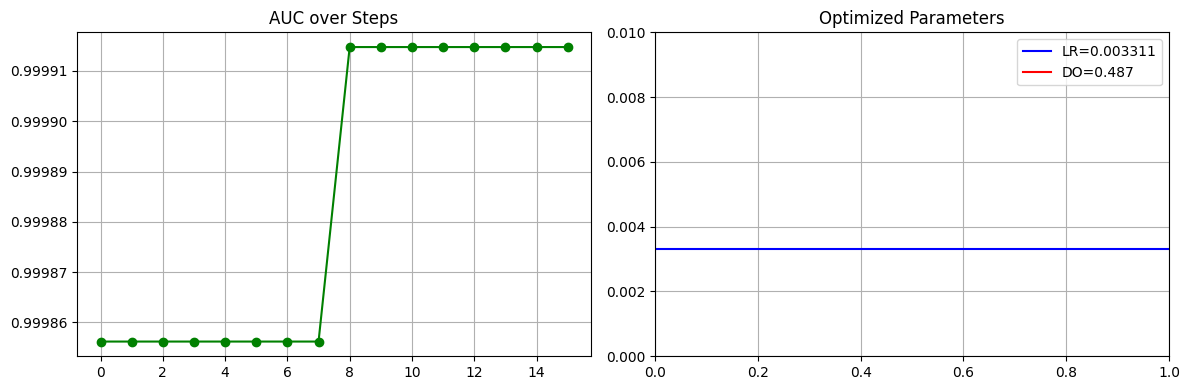

In [ ]:
np.random.seed(42)
best_params, best_auc, hist = hill_climbing(n_steps=15, step_size=0.3)

print(f"\nBEST: LR={best_params[0]:.6f}, Dropout={best_params[1]:.3f}, Val AUC={best_auc:.4f}")


final = build_model(input_shape, lr=best_params[0], dropout=best_params[1])
final.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]),
          epochs=60, batch_size=256,
          validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)

test_auc = roc_auc_score(y_test, final.predict(X_test, verbose=0).ravel())
print(f"\nFINAL TEST AUC: {test_auc:.4f}")


plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(hist, marker='o', color='green'); plt.title('AUC over Steps'); plt.grid()
plt.subplot(1,2,2);
plt.axhline(best_params[0], color='blue', label=f'LR={best_params[0]:.6f}')
plt.axhline(best_params[1], color='red', label=f'DO={best_params[1]:.3f}')
plt.legend(); plt.title('Optimized Parameters'); plt.ylim(0, 0.01 if best_params[0]<0.01 else 1)
plt.grid(); plt.tight_layout(); plt.show()

In [ ]:
def pso_optimize(fitness_func, bounds, n_particles=15, n_iter=6,
                 w=0.7, c1=1.4, c2=1.4, args=()):
    dim = len(bounds); np.random.seed(42)
    low  = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])
    X = np.random.uniform(low, high, (n_particles, dim))
    V = np.random.uniform(-.1, .1, (n_particles, dim))
    pbest = X.copy()
    pbest_obj = np.array([fitness_func(p, *args) for p in pbest])
    gbest_idx = pbest_obj.argmin()
    gbest, gbest_obj = pbest[gbest_idx].copy(), pbest_obj[gbest_idx]
    hist = {'auc':[], 'params':[]}
    for it in range(n_iter):
        print(f"Iter {it+1}/{n_iter} | Best AUC: {-gbest_obj:.4f}")
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            V[i] = w*V[i] + c1*r1*(pbest[i]-X[i]) + c2*r2*(gbest-X[i])
            X[i] = np.clip(X[i]+V[i], low, high)
            obj = fitness_func(X[i], *args)
            if obj < pbest_obj[i]:
                pbest[i], pbest_obj[i] = X[i].copy(), obj
        gbest_idx = pbest_obj.argmin()
        if pbest_obj[gbest_idx] < gbest_obj:
            gbest, gbest_obj = pbest[gbest_idx].copy(), pbest_obj[gbest_idx]
        hist['auc'].append(-gbest_obj); hist['params'].append(gbest.copy())
    return gbest, -gbest_obj, hist

In [ ]:
def build_model(shape, lr=1e-3, dropout=0.2):
    inp = Input(shape=shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x = BatchNormalization()(x); x = Dropout(dropout)(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = BatchNormalization()(x); x = Dropout(dropout)(x)
    x = GlobalAveragePooling1D()(x)
    out = Dense(1, activation='sigmoid', dtype='float32')(x)
    m = Model(inp, out)
    m.compile(Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return m

# ---------- 7. Fitness (tf.data + early stopping) ----------
def fitness(params, X_tr, y_tr, X_va, y_va, shape, subset=0.5, epochs=10):
    lr, do = params
    if not (0.1 <= do <= 0.5): return 10.0
    n = int(len(X_tr) * subset)
    idx = np.random.choice(len(X_tr), n, replace=False)
    ds_tr = tf.data.Dataset.from_tensor_slices((X_tr[idx], y_tr[idx])).batch(64).prefetch(tf.data.AUTOTUNE)
    ds_va = tf.data.Dataset.from_tensor_slices((X_va, y_va)).batch(64).prefetch(tf.data.AUTOTUNE)
    m = build_model(shape, lr=lr, dropout=do)
    m.fit(ds_tr, validation_data=ds_va, epochs=epochs,
          callbacks=[EarlyStopping(patience=3, restore_best_weights=True),
                     ReduceLROnPlateau(factor=0.5, patience=2)],
          verbose=0)
    auc = roc_auc_score(y_va, m.predict(ds_va, verbose=0).ravel())
    return -auc

#  PSO
def pso_optimize(fitness_func, bounds, n_particles=15, n_iter=6,
                 w=0.7, c1=1.4, c2=1.4, args=()):
    dim = len(bounds); np.random.seed(42)
    low  = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])
    X = np.random.uniform(low, high, (n_particles, dim))
    V = np.random.uniform(-.1, .1, (n_particles, dim))
    pbest = X.copy()
    pbest_obj = np.array([fitness_func(p, *args) for p in pbest])
    gbest_idx = pbest_obj.argmin()
    gbest, gbest_obj = pbest[gbest_idx].copy(), pbest_obj[gbest_idx]
    hist = {'auc':[], 'params':[]}
    for it in range(n_iter):
        print(f"Iter {it+1}/{n_iter} | Best AUC: {-gbest_obj:.4f}")
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            V[i] = w*V[i] + c1*r1*(pbest[i]-X[i]) + c2*r2*(gbest-X[i])
            X[i] = np.clip(X[i]+V[i], low, high)
            obj = fitness_func(X[i], *args)
            if obj < pbest_obj[i]:
                pbest[i], pbest_obj[i] = X[i].copy(), obj
        gbest_idx = pbest_obj.argmin()
        if pbest_obj[gbest_idx] < gbest_obj:
            gbest, gbest_obj = pbest[gbest_idx].copy(), pbest_obj[gbest_idx]
        hist['auc'].append(-gbest_obj); hist['params'].append(gbest.copy())
    return gbest, -gbest_obj, hist

Iter 1/6 | Best AUC: 1.0000
Iter 2/6 | Best AUC: 1.0000
Iter 3/6 | Best AUC: 1.0000
Iter 4/6 | Best AUC: 1.0000
Iter 5/6 | Best AUC: 1.0000
Iter 6/6 | Best AUC: 1.0000

Best LR : 0.001826
Best DO : 0.173
Val AUC : 1.0000


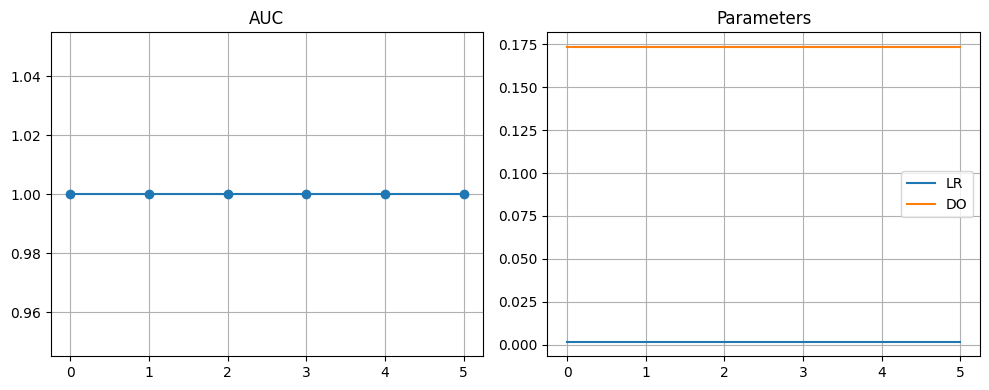

Epoch 1/80
703/703 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9025 - loss: 0.2355 - val_accuracy: 0.9889 - val_loss: 0.0335
Epoch 2/80
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9904 - loss: 0.0340 - val_accuracy: 0.9939 - val_loss: 0.0233
Epoch 3/80
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9932 - loss: 0.0219 - val_accuracy: 0.9954 - val_loss: 0.0184
Epoch 4/80
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9954 - loss: 0.0174 - val_accuracy: 0.9980 - val_loss: 0.0068
Epoch 5/80
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9960 - loss: 0.0142 - val_accuracy: 0.9979 - val_loss: 0.0092
Epoch 6/80
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9967 - loss: 0.0123 - val_accuracy: 0.9886 - val_loss: 0.0421
Epoch 7/80
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9963 - loss: 0.0137 - val_accuracy: 0.9988 - val_loss: 0.0069
Epoch 8/80
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9978 - loss: 0.0075 - v

In [ ]:
bounds = [(1e-5, 1e-2), (0.1, 0.5)]                     # LR, Dropout
pso_args = (X_train, y_train, X_val, y_val, input_shape)

best_par, best_auc, hist = pso_optimize(
    fitness, bounds, n_particles=15, n_iter=6,
    w=0.7, c1=1.4, c2=1.4, args=pso_args)

print("\nBest LR :", f"{best_par[0]:.6f}")
print("Best DO :", f"{best_par[1]:.3f}")
print("Val AUC :", f"{best_auc:.4f}")

# ---------- 10. Plot convergence ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist['auc'], marker='o'); plt.title('AUC'); plt.grid()
plt.subplot(1,2,2);
plt.plot([p[0] for p in hist['params']], label='LR')
plt.plot([p[1] for p in hist['params']], label='DO')
plt.legend(); plt.title('Parameters'); plt.grid()
plt.tight_layout(); plt.show()

# ---------- 11. Final model on train+val ----------
final = build_model(input_shape, lr=best_par[0], dropout=best_par[1])
final.fit(np.concatenate([X_train, X_val]),
          np.concatenate([y_train, y_val]),
          epochs=80, batch_size=64,
          validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
          verbose=1)

test_auc = roc_auc_score(y_test, final.predict(X_test, verbose=0).ravel())
print(f"\nFINAL TEST AUC (1 000 patients): {test_auc:.4f}")